### Plot the results from my simulated data

In [1]:
from plotnine import *
%matplotlib inline
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from rich.progress import track
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
import numpy as np

In [2]:
genpath='/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome'

In [3]:
human=pd.read_csv(genpath+'/IBM/final/h_1000/simData.csv')
animal= pd.read_csv(genpath+'/IBM/final/a_1000/simData.csv')

## Filter them
human_filtered=human.copy()
animal_filtered=animal.copy()

# Make a df that only has the highest ct per sim
human_filtered=human_filtered.sort_values(['sim','ct'], ascending=False).drop_duplicates(['sim']).dropna()
animal_filtered=animal_filtered.sort_values(['sim', 'ct'], ascending=False).drop_duplicates(['sim']).dropna()


In [4]:
animal_filtered=animal_filtered[np.isfinite(animal_filtered)==True]
human_filtered=human_filtered[np.isfinite(human_filtered)==True]

In [5]:
features=['Length', 'Simpson']
human_filtered[features]=human_filtered[features].apply(lambda x: np.log(x))
animal_filtered[features]=animal_filtered[features].apply(lambda x: np.log(x))

In [6]:
human_filtered.head()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e
14335,999,180.0,2.893717,43.0,16.0,2.189681,0.558273
14294,998,120.0,2.498661,16.0,8.0,1.593934,0.615385
14237,997,180.0,2.890894,67.0,15.0,1.686755,0.360128
14138,996,110.0,2.468981,19.0,12.0,2.277960,0.813063
14060,995,110.0,2.394846,11.0,9.0,2.087740,0.896296


In [7]:
animal_filtered.head()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e
47516,999,740.0,8.921106,84133.0,39.0,2.200860,0.231610
47341,998,870.0,9.071264,20806.0,45.0,2.822152,0.373622
47245,997,450.0,8.426698,58984.0,27.0,2.354876,0.390253
47193,996,410.0,8.338082,31815.0,23.0,2.203777,0.393877
47148,995,330.0,8.100239,5656.0,29.0,2.694117,0.510085


In [8]:
def get_results(feature):
    """Get a single association.
    
    As long as `args` and `df` are assigned this can be used on
    any data set.
    """
    formula = f"{feature} ~ Length"
    fitted = ols(formula, data=df).fit()
    return pd.DataFrame({
        "feature": feature,
        "beta": fitted.params["Length"],
        "t_statistic": fitted.tvalues["Length"],
        "p": fitted.pvalues["Length"],
        "n": fitted.nobs, 
        'rsquared':fitted.rsquared
        }, index=[feature])

args=['Simpson']

In [9]:
df = human_filtered
results = map(get_results, track(args))
results = list(results)
human_tests = pd.concat(results)
human_tests["q"] = multipletests(human_tests.p, method="fdr_bh")[1]
human_tests['data']='human'

Output()

In [10]:
df = animal_filtered
results = map(get_results, track(args))
results = list(results)
animal_tests = pd.concat(results)
animal_tests["q"] = multipletests(animal_tests.p, method="fdr_bh")[1]
animal_tests['data']='animal'

all_tests=pd.concat([animal_tests, human_tests])
all_tests

Output()

,feature,beta,t_statistic,p,n,rsquared,q,data
Simpson,Simpson,0.300077,22.692162,2.960742e-92,1000.0,0.340355,2.960742e-92,animal
Simpson,Simpson,0.413985,8.687060,1.500385e-17,1000.0,0.070300,1.500385e-17,human


In [11]:
all_tests=all_tests.set_index('data')
all_tests

,feature,beta,t_statistic,p,n,rsquared,q
data,,,,,,,
animal,Simpson,0.300077,22.692162,2.960742e-92,1000.0,0.340355,2.960742e-92
human,Simpson,0.413985,8.687060,1.500385e-17,1000.0,0.070300,1.500385e-17


In [12]:
animal_filtered.head()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e
47516,999,740.0,8.921106,84133.0,39.0,2.200860,0.231610
47341,998,870.0,9.071264,20806.0,45.0,2.822152,0.373622
47245,997,450.0,8.426698,58984.0,27.0,2.354876,0.390253
47193,996,410.0,8.338082,31815.0,23.0,2.203777,0.393877
47148,995,330.0,8.100239,5656.0,29.0,2.694117,0.510085


In [13]:
a_p=all_tests.loc['animal', 'p']
a_p= f'p={a_p:.2E}'
a_rsq=all_tests.loc['animal', 'rsquared']
h_p=all_tests.loc['human', 'p']
h_p=f'p={h_p:.2E}'
h_rsq=all_tests.loc['human', 'rsquared']

In [14]:
import matplotlib.transforms as mtransforms

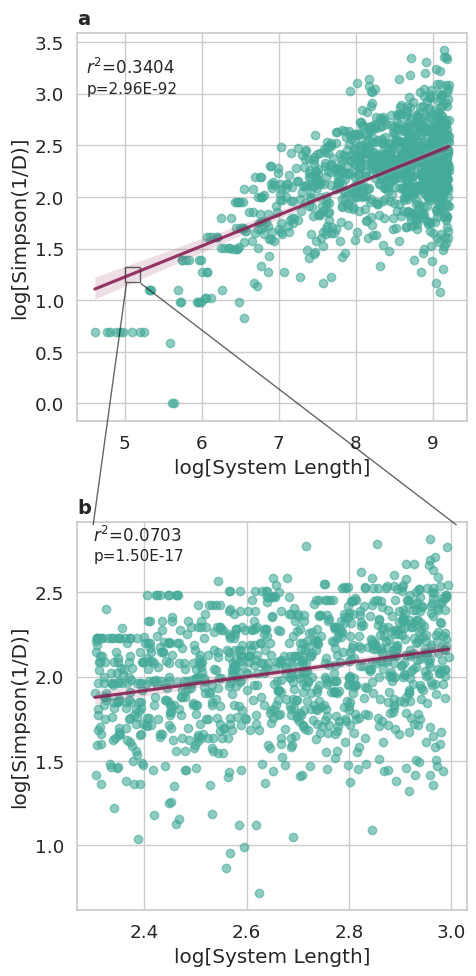

In [15]:
sns.set_theme(style='whitegrid', font_scale=1.2)
fig, axs =plt.subplots(2,1,figsize=(5,10), tight_layout=True)
fig.subplots_adjust(left=0.5, right=0.6, top=0.5)

x='Length'
y ='Simpson'

axs[0] = sns.regplot(data=animal_filtered, ax=axs[0], x=x, y=y,\
            scatter_kws={'alpha':0.6, 'color':'#44AA99'},\
            line_kws={'color':'#882255', 'alpha':0.9})
                    
axs[0].set(xlabel='log[System Length]', ylabel='log[Simpson(1/D)]')
axs[0].set_title('a', loc='left', fontweight='bold', fontsize=14)
axs[0].text(4.5,3, a_p, fontsize=11)
axs[0].text(4.5,3.2, f'$r^2$={a_rsq:.4f}', fontsize=12)

axs[1] = sns.regplot(data=human_filtered, ax=axs[1], x=x, y=y,\
            scatter_kws={'alpha':0.6, 'color':'#44AA99'},\
            line_kws={'color':'#882255', 'alpha':0.9})
                   
axs[1].set(xlabel='log[System Length]', ylabel='log[Simpson(1/D)]')
axs[1].set_title('b',loc='left', fontweight='bold', fontsize=14) 
axs[1].text(2.3, 2.69, h_p, fontsize=11)
axs[1].text(2.3, 2.8, f'$r^2$={h_rsq:.4f}',fontsize=12)

rectangle=Rectangle((5.,1.175),0.2,0.15, color='black', alpha=0.6, fill=False)
axs[0].add_patch(rectangle)
con1 = ConnectionPatch(xyA=(5.02,1.16), xyB=(2.3,2.9), coordsA='data', coordsB='data',\
                      axesA=axs[0], axesB=axs[1], color='black', linewidth=1, alpha=0.6)
con2 = ConnectionPatch(xyA=(5.21,1.16), xyB=(3.01,2.9), coordsA='data', coordsB='data',\
                      axesA=axs[0], axesB=axs[1], color='black', linewidth=1, alpha=0.6)
fig.add_artist(con1)
fig.add_artist(con2)


In [16]:
fig.savefig(genpath+'/output/all_sim_data.pdf')